<img src="../imgs/logo.png" width="20%" align="right" style="margin:0px 20px">


# Evolutionary Computation

## 2.1 Genetic Algorithms

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-sa/4.0/80x15.png" /></a>&nbsp;| Dennis G. Wilson | <a href="https://d9w.github.io/evolution/">https://d9w.github.io/evolution/</a>

## Outline

1. [Genetic Algorithm Overview](#overview)
2. [Initialization](#populations)
3. [Selection](#selection)
4. [Mutation](#mutation)
5. [Crossover](#crossover)
6. [Putting it all together](#together)
7. [Elitism](#elitism)

In [35]:
using Random
using Statistics
using StatsBase
using Plots

## <a id="overview"></a>Genetic Algorithm Overview

Recall the outline of evolutionary algorithms that we discussed in section 1.2. The outline of an evolutionary algorithm is to start with an initial population and then to iterate through a cycle of evaluation, selection, and modification, passing the modified population on as the next generation.

<img src="../imgs/AlgoG.png">

This is the underlying algorithm of a genetic algorithm. This term is general and can cover a variety of more specific algorithms such as NSGA-II and NEAT, but in this section we'll discuss a classic genetic algorithm.

The defining features of a classic genetic algorithm are a large population initialized at random and the mutation and crossover operators during the modification step. In a classic GA, we will use a selection method to randomly select two individuals from the population, combine them using crossover, mutate the resulting individual, and add it to the new population. We will repeat this until the new population is full. Let's write that basic outline as a function.

In [19]:
abstract type Individual end

function step_ga(population::Array{<:Individual})
    evaluate!(population)
    max_fit = maximum([i.fitness for i in population])
    
    new_population = Array{Individual}(undef, 0)
    while length(new_population) < length(population)
        parent1 = select(population)
        parent2 = select(population)
        child1 = crossover(parent1, parent2)
        child1 = mutate(child1)
        push!(new_population, child1)
    end
    
    new_population, max_fit
end

step_ga (generic function with 1 method)

We've defined a single step of the genetic algorithm and can fill in the functions later. Let's now define the full evolution, keeping track of the maximum fitness in the population at each step.

In [20]:
function ga(n_generations::Int)
    population = initialize()
    fits = zeros(n_generations)
    
    for i in 1:n_generations
        population, max_fit = step_ga(population)
        fits[i] = max_fit
    end
    
    fits
end

ga (generic function with 1 method)

## <a id="initialization"></a>Initialization

Earlier we saw a new bit of Julia:
```
abstract type Individual end
```
This let us use the type `Array{Individual}` in our function definition even though a concrete definition of `Individual` hasn't been used yet. In the last notebook, we had to redefine functions in order to switch between the boolean `Individual` and the `FloatIndividual`.  Abstract types let us define functions which can work for either type, as long as they are subtypes of this abstract. This is known as multiple dispatch and we'll use it to define the later parts of our genetic algorithm. Let's define our two `Individual` types for now.

In [21]:
mutable struct BitInd <: Individual
    genes::BitArray
    fitness::Float64
end

function BitInd(n::Int)
    BitInd(bitrand(n), -Inf)
end

BitInd

In [22]:
mutable struct FloatInd <: Individual
    genes::Array{Float64}
    fitness::Float64
end

function FloatInd(n::Int)
    FloatInd(rand(n), -Inf)
end

FloatInd

This will be very useful later, but for now just remember that we still have our two different types, `BitInd` and `FloatInd`, but that we can refer to both using `Individual`. Let's create population initialization methods for these two types.

In [23]:
function bit_init(population_size::Int, n::Int)
    [BitInd(n) for i in 1:population_size]
end

function float_init(population_size::Int, n::Int)
    [FloatInd(n) for i in 1:population_size]
end

float_init (generic function with 1 method)

Let's see our different populations:

In [24]:
population = bit_init(100, 4)
population[1:3]

3-element Vector{BitInd}:
 BitInd(Bool[1, 1, 0, 1], -Inf)
 BitInd(Bool[1, 0, 0, 1], -Inf)
 BitInd(Bool[1, 1, 0, 0], -Inf)

In [25]:
population = float_init(100, 4)
population[1:3]

3-element Vector{FloatInd}:
 FloatInd([0.6339714172092401, 0.13733245978694675, 0.5182587672988392, 0.6461753733478401], -Inf)
 FloatInd([0.026222681523103475, 0.0577227531018214, 0.9698958350272224, 0.9709069615365611], -Inf)
 FloatInd([0.425921815684724, 0.4261089487860408, 0.1018706100067579, 0.8393245250702455], -Inf)

## <a id="populations"></a>Evaluation

The first part of the genetic algorithm step is the evaluation. We'll look at two evaluation functions, one for our binary individual type, and one for the floating point individuals.

Looking at our genetic algorithm implementation, we use an `evaluate!` function to evaluate the entire population. Let's write that general function.

In [26]:
function evaluate!(population::Array{<:Individual})
    for i in population
        i.fitness = objective(i)
    end
end

evaluate! (generic function with 1 method)

Note the `<:Individual` in our definition of `population`. This means that population is expected to be an `Array` of any subtype of `Individual`, meaning `BitInd` or `FloatInd`. This evaluate function will work for both types then. Let's write individual objective functions for these two different types. For the binary type, we'll use the OneMax function again.

In [27]:
function objective(i::BitInd)
    sum(i.genes)
end

objective (generic function with 2 methods)

Let's test that.

In [28]:
population = bit_init(10, 4)
evaluate!(population)
print([i.fitness for i in population])

[2.0, 2.0, 2.0, 3.0, 1.0, 2.0, 2.0, 1.0, 2.0, 3.0]

For a floating point problem, let's look at something a bit more difficult than the sphere problem. Specifically, we'll use the [Rastrigin function](https://en.wikipedia.org/wiki/Test_functions_for_optimization).

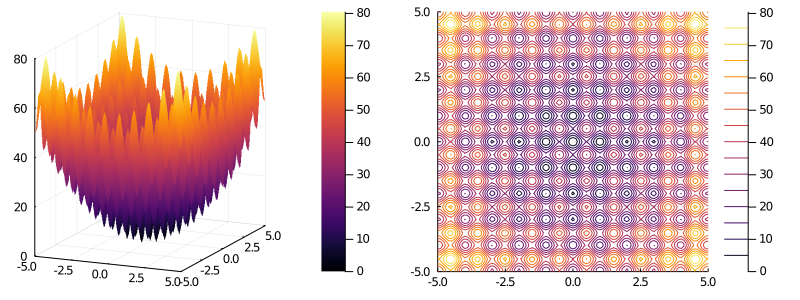

In [29]:
rastrigin(x) = 10*length(x) .+ sum(x.^2 .- 10 .* cos.(2*pi*x))

x = -5:0.1:5
y = -5:0.1:5
fz(x, y) = rastrigin([x, y])
plot(plot(x, y, fz, st=:surface), plot(x, y, fz, st=:contour), size = (800, 300))

We'll use a smaller section of the rastrigin function for demonstration, but you can also try the Genetic Algorithm on the entire space as an exercise.

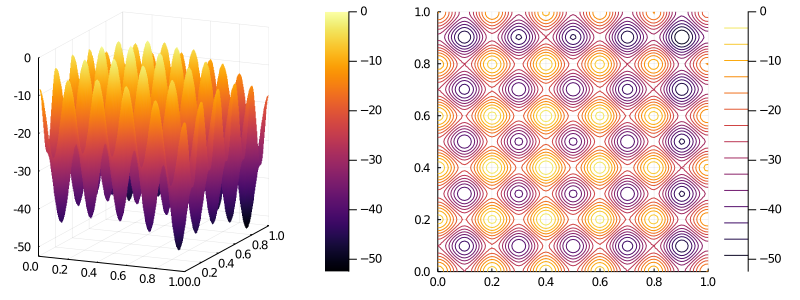

In [74]:
x = 0:0.01:1
y = 0:0.01:1
fz(x, y) = -rastrigin([x*5-2, y*5-2])
#fz(x, y) = exp(-rastrigin([x*5-2, y*5-2]))
plot(plot(x, y, fz, st=:surface), plot(x, y, fz, st=:contour), size = (800, 300))

Let's define our second objective function using this. Note that we'll also just call it `objective`, like the one we defined before. However, we'll be making a second function which applies to the `FloatInd` type.

In [31]:
function objective(i::FloatInd)
    -rastrigin(i.genes .* 5 .- 2)
end

objective (generic function with 2 methods)

We can see the different functions we've defined used `methods`

In [32]:
methods(objective)

# 2 methods for generic function "objective":
[1] objective(i::BitInd) in Main at In[27]:1
[2] objective(i::FloatInd) in Main at In[31]:1

Let's see what our first population of floating point individuals looks like in the Rastrigin function **search space**.

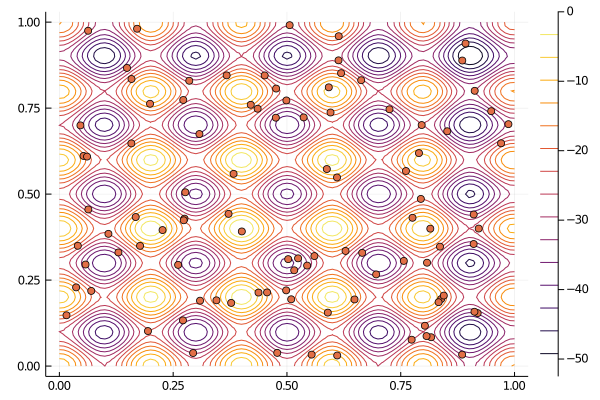

In [33]:
population = float_init(100, 10)
xs = [i.genes[1] for i in population]
ys = [i.genes[2] for i in population]
plot(x, y, fz, st=:contour)
scatter!(xs, ys, label="pop", legend=:none)

As we can see, having a large population of individuals means we have a chance of already starting out in a good position. However, some others might be in **local maxima** - points which are higher than the areas around them, but not the **global maximum**. These points can be deceptive if we tend to select only the individuals in high points. What we want to do with selection in a genetic algorithm is maintain **diversity** while moving towards the **global maximum**. Let's see how we can do that.

<div class="alert alert-success">
    <b>Exercise 1</b>
    <br/>
Visualize the sphere function from the first class. Why do you think the Rastrigin function is more difficult than the sphere function? Is there any other function which looks more difficult?
    <br/>
</div>

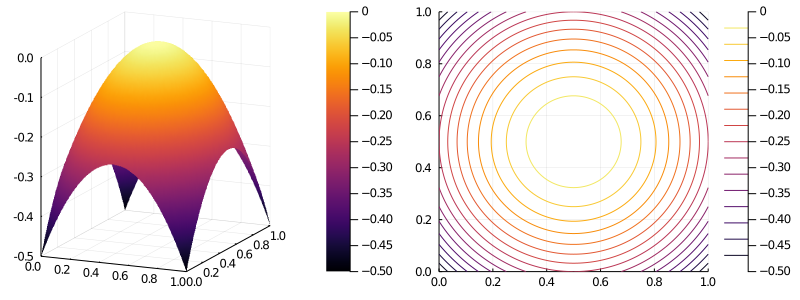

In [69]:
sphere(x, y) = (x)^2 + (y)^2

x = 0:0.01:1
y = 0:0.01:1

fz(x, y) = -sphere(x-0.5, y-0.5)

plot(plot(x, y, fz, st=:surface), plot(x, y, fz, st=:contour), size = (800, 300))

# The sphere function only has one minima, it is therefore much easier for the search algorithm to find it
# and to not get trapped in a local minimum
# https://en.wikipedia.org/wiki/Test_functions_for_optimization lists different benchmarking functions
# for optimization algorithms. The Eggholder function looks for example more difficult.

## <a id="selection"></a>Selection

Which individuals should pass on their genetic information to the next generation? We could imagine a simple schemes of taking the best individuals globally, say 20% of them, and mutating each of these experts for the next generation. In a simple problem like this one, such a method might work. However, we would lose important genetic diversity, one of the main advantages of our large population. Let's explore some different selection methods. To do so, we'll need to evaluate all individuals.

For this first proposed method of taking the top individuals, which is called **truncation selection**, we'll need to order them. In Julia, we can override any function, including the basic functions of the language. To order our population, we can use the main `sort!` method, which relies on being able to compare individuals using `<`. So let's make a new definition for the `<`, or `isless`, function.

In [61]:
import Base.isless

function isless(i1::Individual, i2::Individual)
    i1.fitness < i2.fitness
end
evaluate!(population)
println(population[1])
println(population[2])
println(population[1] < population[2])

FloatInd([0.5957639391561018, 0.7372351855558015, 0.9326491208737202, 0.40526203827438656, 0.3977175723822295, 0.34950892648568166, 0.01431382108248358, 0.03700120331145307, 0.27649591431665743, 0.9905267185575848], -91.42246413183864)
FloatInd([0.0636223046306923, 0.4553604464248262, 0.2595087832330125, 0.6856772115200476, 0.14712555113378234, 0.03848934436792795, 0.08585559475697546, 0.4559946651217064, 0.8707138598662385, 0.910343573263207], -166.4743859340921)
false


Now that we have a way of comparing individuals, we can order lists of them using the `sort!` function. We'll sort from biggest to smallest to have the best individuals at the beginning of the population.

In [62]:
population = float_init(100, 2)
evaluate!(population)
fits = [i.fitness for i in population]
println("First: ", population[1].fitness, ", last :", population[end].fitness)
println("Max: ", maximum(fits), ", min: ", minimum(fits))

First: -25.99823172629472, last :-26.785582730351617
Max: -1.1222623870641968, min: -49.96023513423781


In [63]:
sort!(population, rev=true)
println("First: ", population[1].fitness, ", last :", population[end].fitness)
println("Max: ", maximum(fits), ", min: ", minimum(fits))

First: -1.1222623870641968, last :-49.96023513423781
Max: -1.1222623870641968, min: -49.96023513423781


Let's plot where our best individuals are

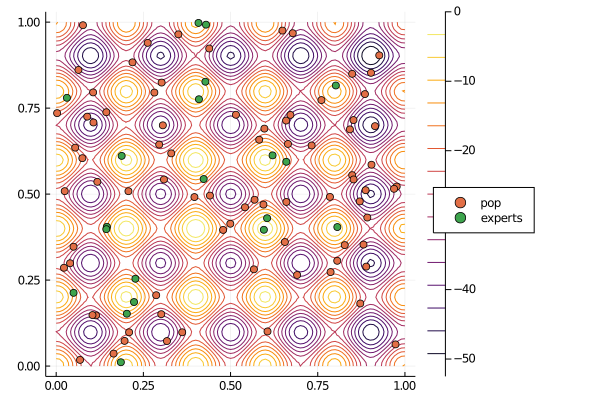

In [66]:
xs = [i.genes[1] for i in population]; ys = [i.genes[2] for i in population]
plot(x, y, fz, st=:contour)
scatter!(xs[21:end], ys[21:end], label="pop", legend=:outerright)
scatter!(xs[1:20], ys[1:20], label="experts")

As we can see, using this selection method, we risk optimizing towards local maxima, especially if we completely discard the rest of the population. Let's look at other selection methods for now, and we'll keep truncation selection in mind for later.

We will instead assign a probability to each individual based on their fitness. This is known as **fitness proportionate selection**. Specifically, we will use the probability

$p_i = \frac{f_i}{\sum_{j=1}^N f_j}$

The probability is each fitness divided by the sum. We'll use the `.` dot broadcast operator in Julia to divide each element of `fits` by the sum.

In [67]:
fits = [i.fitness for i in population]
p = fits ./ sum(fits);

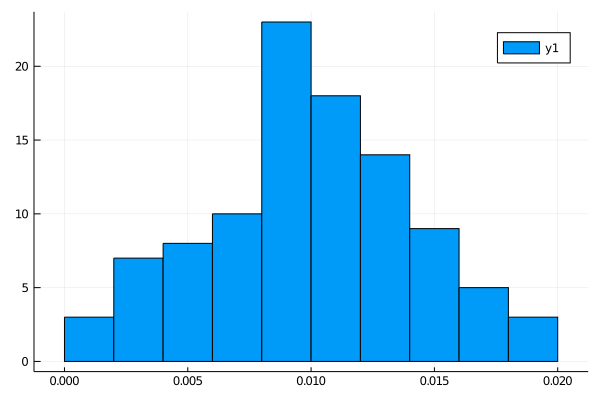

In [68]:
histogram(p)

We can use these weights to sample from our population using the `sample` function from the `StatsBase` package

In [198]:
sample(population, Weights(p))

BitInd(Bool[1, 1, 0, 1, 1, 0, 0, 0, 0, 1  …  0, 1, 0, 0, 1, 0, 0, 0, 0, 0], 50.0)

Let's write this according to the `select` function definition we used before, which takes in the population and gives out a single individual.

In [71]:
function fp_select(population::Array{<:Individual})
    fits = [-i.fitness for i in population]
    fits = maximum(fits) .- fits
    p = fits ./ sum(fits)
    sample(population, Weights(p))
end

fp_select (generic function with 1 method)

Does this perform better than our previous method? Let's select 20 individuals using this method.

In [72]:
selected = Array{Individual}(undef, 20)
for i in eachindex(selected)
    selected[i] = fp_select(population)
end

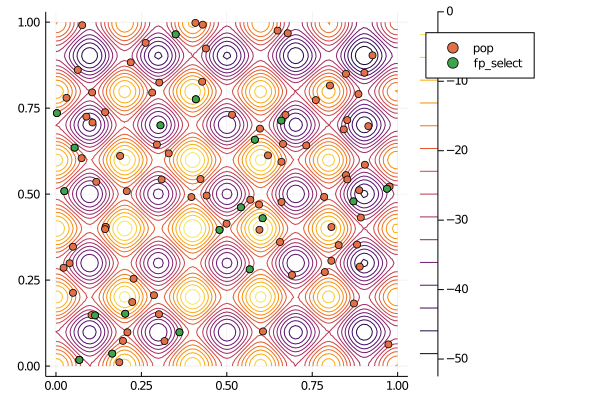

In [75]:
sxs = [i.genes[1] for i in selected]
sys = [i.genes[2] for i in selected]
xs = [i.genes[1] for i in population]
ys = [i.genes[2] for i in population]
plot(x, y, fz, st=:contour)
scatter!(xs, ys, label="pop", legend=:outertopright)
scatter!(sxs, sys, label="fp_select")

As we can see here, individuals are not only found in local maxima but throughout the search space, which is good for diversity. The last selection method we'll use is called tournament selection. This method creates small random tournaments and selects the winner from this smaller subset for every new individual. We'll use a tournament size of 3, so we'll randomly select 3 individuals and then return the best individual from those 3.

In [164]:
function tournament_select(population::Array{<:Individual})
    tournament = sample(population, 3)
    sort!(tournament, rev=true)[1]
end

tournament_select (generic function with 1 method)

Let's look at 20 selections from the tournament selection method and compare it to the fitness proportionate method.

In [77]:
winners = Array{Individual}(undef, 20)
for i in eachindex(winners)
    winners[i] = tournament_select(population)
end

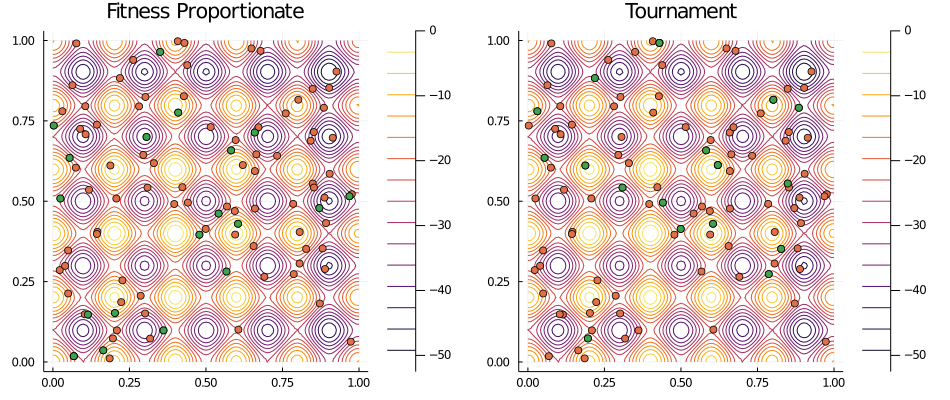

In [78]:
wxs = [i.genes[1] for i in winners]
wys = [i.genes[2] for i in winners]
p1 = plot(x, y, fz, st=:contour)
scatter!(xs, ys, legend=:none)
scatter!(sxs, sys)
title!("Fitness Proportionate")
p2 = plot(x, y, fz, st=:contour)
scatter!(xs, ys, legend=:none)
scatter!(wxs, wys)
title!("Tournament")
plot(p1, p2, size=(950, 400))

<div class="alert alert-success">
    <b>Exercise 2</b>
    <br/>
    Plot the histogram of fitness values of 100 selected individuals using these two methods, and using a larger $n$ value. How do the distributions from the two methods compare? Try it also for a population of binary individuals on the OneMax function. Finally, try increasing the tournament size. What effect does that have on the selected individuals' fitness distribution?
    <br/>
</div>

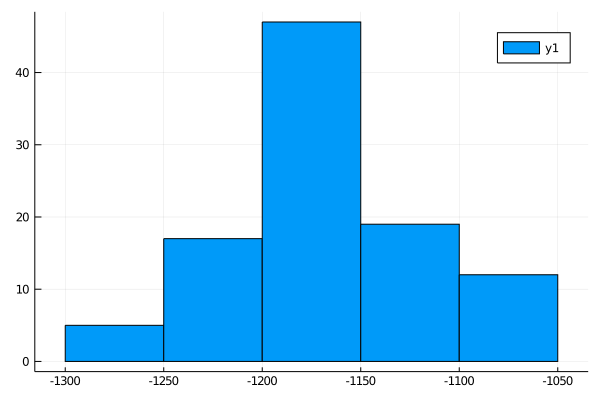

In [237]:
# histogram tournament selection
population = float_init(10000, 100)

evaluate!(population)
fits = [i.fitness for i in population]

winners = Array{Individual}(undef, 100)

for i in eachindex(winners)
    winners[i] = tournament_select(population)
end

fitness_tournament = [i.fitness for i in winners]

histogram(fitness_tournament)

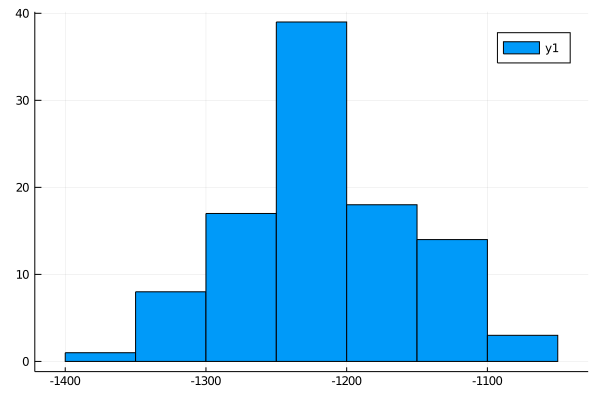

In [209]:
# histogram fitness proportionate
population = float_init(100000, 100)

evaluate!(population)
fits = [i.fitness for i in population]

selected = Array{Individual}(undef, 100)

for i in eachindex(selected)
    selected[i] = fp_select(population)
end

fitness_fp = [i.fitness for i in selected]

histogram(fitness_fp)

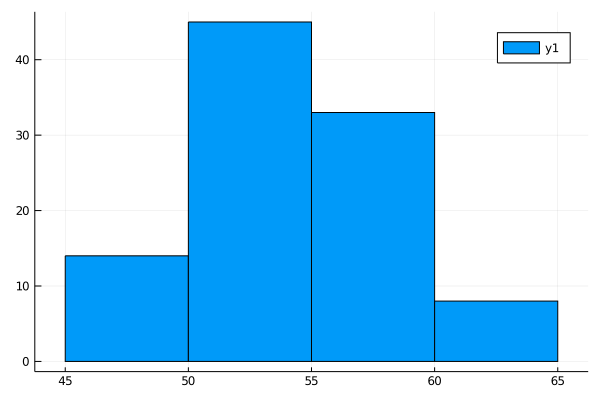

In [210]:
# histogram tournament selection binary
population = bit_init(10000, 100)

evaluate!(population)
fits = [i.fitness for i in population]

winners = Array{Individual}(undef, 100)

for i in eachindex(winners)
    winners[i] = tournament_select(population)
end

fitness_tournament = [i.fitness for i in winners]

histogram(fitness_tournament)

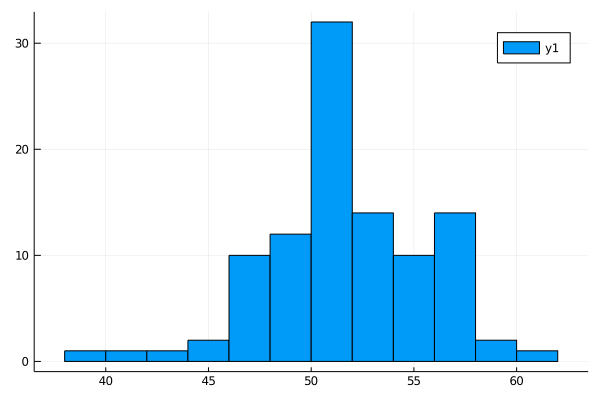

In [231]:
# histogram fitness proportionate binary
population = bit_init(10000, 100)

evaluate!(population)
fits = [i.fitness for i in population]

selected = Array{Individual}(undef, 100)

for i in eachindex(selected)
    selected[i] = fp_select(population)
end

fitness_fp = [i.fitness for i in selected]

histogram(fitness_fp)

In [396]:
function tournament_select(population::Array{<:Individual}; tournament_size::Integer=3)
    tournament = sample(population, tournament_size)
    sort!(tournament, rev=true)[1]
end

tournament_select (generic function with 1 method)

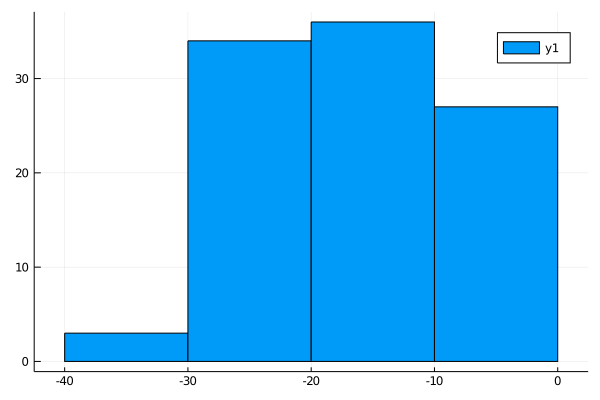

In [309]:
# histogram tournament selection
population = float_init(10000, 2)

evaluate!(population)
fits = [i.fitness for i in population]

winners = Array{Individual}(undef, 100)

for i in eachindex(winners)
    winners[i] = tournament_select(population)
end

fitness_tournament = [i.fitness for i in winners]

histogram(fitness_tournament)

## <a id="mutation"></a>Mutation

For this genetic algorithm, we'll simply reuse the functions we defined in section 1.3. We will flip the gene bit for binary individuals and use `rand` for floating point individuals.

In [382]:
function mutate(ind::BitInd; mutation_rate::Float64=1.0/length(ind.genes))
    new_genes = copy(ind.genes)
    for i in eachindex(new_genes)
        if rand() < mutation_rate
            new_genes[i] = ~ind.genes[i]
        end
    end
    BitInd(new_genes, -Inf)
end

mutate (generic function with 2 methods)

In [383]:
function mutate(ind::FloatInd; mutation_rate::Float64=1.0/length(ind.genes))
    new_genes = copy(ind.genes)
    for i in eachindex(new_genes)
        if rand() < mutation_rate
            new_genes[i] = rand()
        end
    end
    FloatInd(new_genes, -Inf)
end

mutate (generic function with 2 methods)

Let's test it

In [103]:
println(population[1])
println(mutate(population[1]))

FloatInd([0.9427952996319802, 0.08316736763706079, 0.3480982015091647, 0.9943643296124753, 0.21002653245997727, 0.0019591807772856296, 0.7537412749169723, 0.05944281151215702, 0.1215482914900643, 0.11824124034086458], -133.67876776056096)
FloatInd([0.9427952996319802, 0.08316736763706079, 0.47898577216448524, 0.9943643296124753, 0.21002653245997727, 0.0016234503634098285, 0.7537412749169723, 0.05944281151215702, 0.1215482914900643, 0.11824124034086458], -Inf)


<div class="alert alert-success">
    <b>Exercise 3</b>
    <br/>
    Our mutation operator samples from the entire space. Can we instead use the previous gene value as a starting point for mutation? Implement a new mutation operator that adds a small random value between -0.1 and 0.1 to the modified gene.
    <br/>
</div>

In [276]:
function mutate_mod(ind::FloatInd; mutation_rate::Float64=1.0/length(ind.genes))
    new_genes = copy(ind.genes)
    for i in eachindex(new_genes)
        if rand() < mutation_rate
            new_genes[i] = ind.genes[i] + 0.2 * rand() - 0.1
        end
    end
    FloatInd(new_genes, -Inf)
end

mutate_mod (generic function with 1 method)

In [281]:
population = float_init(100, 2)

println(population[1])
println(mutate_mod(population[1]))

FloatInd([0.8630506503508848, 0.018587771587691204], -Inf)
FloatInd([0.811258870730179, 0.09938752045062396], -Inf)


## <a id="crossover"></a>Crossover

Considering we have such a large population, is there some way to combine individual solutions to lead to better solutions? For example, could we make an individual which inherits information from two parent individuals? This is the idea behind crossover, the other operator in genetic algorithms besides mutation. It is based on sexual reproduction where the genetic information of two parent individuals is mixed to create an offspring individual. The idea of combining the information from multiple individuals together to create the next generation is something we'll explore in more detail next class when discussing evolutionary strategies. For now, let's look at ways to combine two individuals.

<img src="../imgs/crossover.png" width="80%" height="auto">

The first methods we'll look at is single-point crossover. Here, the child genes are composed of two continuous sections, the first from one parent and the second from the other parent.

In [104]:
function one_point_crossover(p1::Individual, p2::Individual)
    child = copy(p1.genes)
    n = rand(1:length(p2.genes))
    child[n:end] = copy(p2.genes[n:end])
    typeof(p1)(child, -Inf)
end

one_point_crossover (generic function with 1 method)

Let's test that

In [107]:
p1 = BitInd(15)
p2 = BitInd(15)
println("P1: ", p1)
println("P2: ", p2)
child = one_point_crossover(p1, p2)
println("C : ", child)

P1: BitInd(Bool[1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1], -Inf)
P2: BitInd(Bool[1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1], -Inf)
C : BitInd(Bool[1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1], -Inf)


This is most useful when sequential sections of a genome should be passed together, which is the case in biological evolution but not always necessary in artificial evolution. This method is also the basis of k-point crossover, which follows the same method but splits at $k$ points, alternating between parents at each crossing point. Note that this method can generate two children at once, but for the sake of coherence we'll just use the first child.

The second crossover method we'll look at is uniform crossover, which randomly chooses a different parent for each gene.

In [108]:
function uniform_crossover(p1::Individual, p2::Individual)
    child = copy(p1.genes)
    for i in eachindex(child)
        if rand() < 0.5
            child[i] = p2.genes[i]
        end
    end
    typeof(p1)(child, -Inf)
end

uniform_crossover (generic function with 1 method)

And the test

In [109]:
p1 = BitInd(15)
p2 = BitInd(15)
println("P1: ", p1)
println("P2: ", p2)
child = one_point_crossover(p1, p2)
println("C : ", child)

P1: BitInd(Bool[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], -Inf)
P2: BitInd(Bool[1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0], -Inf)
C : BitInd(Bool[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], -Inf)


<div class="alert alert-success">
    <b>Exercise 4</b>
    <br/>
    Which crossover method do you expect to work better for the OneMax problem? What about for the Rastrigin function? Explain your reasoning.
    <br/>
</div>

In [110]:
# In both problems the sequence of genes is not important, so it can be expected that they either all
# work equally good or there is an advantage for the uniform_crossover algorithm

## <a id="together"></a>Putting it all together

Let's look back at the functions we defined earlier

In [111]:
function step_ga(population::Array{<:Individual})
    evaluate!(population)
    max_fit = maximum([i.fitness for i in population])
    
    new_population = Array{Individual}(undef, 0)
    while length(new_population) < length(population)
        parent1 = select(population)
        parent2 = select(population)
        child1 = crossover(parent1, parent2)
        child1 = mutate(child1)
        push!(new_population, child1)
    end
    
    new_population, max_fit
end

step_ga (generic function with 1 method)

In [112]:
function ga(n_generations::Int)
    population = initialize()
    fits = zeros(n_generations)
    
    for i in 1:n_generations
        population, max_fit = step_ga(population)
        fits[i] = max_fit
    end
    
    fits
end

ga (generic function with 1 method)

We need to define our function choices for `initialize`, `select`, and `crossover`. Let's focus on the Rastrigin function and use uniform crossover. We'll compare the two selection methods, starting with fitness proporitionate selection.

In [113]:
initialize() = float_init(100, 10)
crossover = uniform_crossover

uniform_crossover (generic function with 1 method)

In [114]:
select = fp_select
fits_fp = zeros(100, 10)
for i in 1:10
    fits_fp[:, i] = ga(100)
    println(i, " ", fits_fp[end, i])
end

1 -18.070187767481528
2 -13.593612997067922
3 -12.376481358697944
4 -20.779297608273225
5 -20.93391419052149
6 -13.788775958265774
7 -22.794742814987956
8 -14.185760642592555
9 -20.05690879939948
10 -32.49199639562494


In [118]:
select = tournament_select
fits_tourney = zeros(100, 10)
for i in 1:10
    fits_tourney[:, i] = ga(100)
    println(i, " ", fits_tourney[end, i])
end

1 -3.814097808362561
2 -3.7924633923556144
3 -3.9823085386905035
4 -2.266788084598204
5 -5.575441651642194
6 -3.3776109475260228
7 -2.216077285625147
8 -2.648852607533456
9 -3.826179383951839
10 -2.2521313448164904


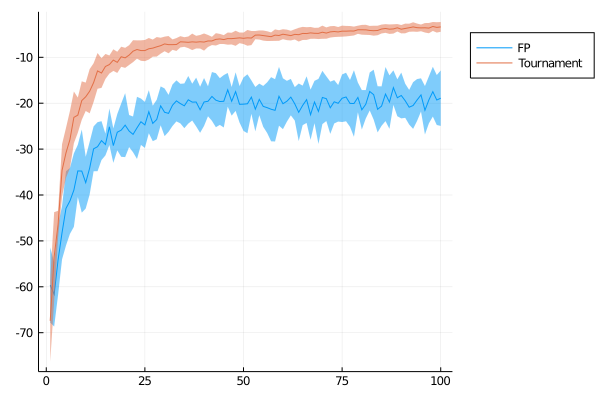

In [119]:
μ_fp = mean(fits_fp, dims=2)
σ_fp = std(fits_fp, dims=2)
μ_tourney = mean(fits_tourney, dims=2)
σ_tourney = std(fits_tourney, dims=2)
plot(μ_fp, ribbon=σ_fp, label="FP", legend=:outertopright)
plot!(μ_tourney, ribbon=σ_tourney, label="Tournament")

While the randomness of tournament selection may appear disadvantageous, the diversity it provides in the search allows us to continue looking through new areas where we might get stuck with fitness proportionate selection. Tournament selection also gaurantees improvement by selecting individuals that are at least better than two other individuals in the population, while fitness proportionate selection may randomly choose bad individuals often.

Our results seem to fluctuate quite a bit. Why is that? We didn't see that before with the $(1+1)$ and $(1+\lambda)$ EAs...

## <a id="elitism"></a>Elitism

An advantage that the $(1+1)$ and $(1+\lambda)$ EAs have over the genetic algorithm we've coded here is that their convergence is **monotonically increasing**. This means as evolution goes on, the result will only improve and never get worse. This is because the best fitness is only ever removed when the expert is replaced by an equally good or better individual. However, neither of the selection methods we compared have this guarantee: the best individual can leave the population easily! While completely basing our selection on global competition may not be a good practice, we do want to keep at least the best individual. This is known as **elitism** and is the practice of directly passing on a certain number of individuals *without mutation* into the next generation. This is similar to the truncation selection we used at the beginning, but the individuals selected from truncation selection will bypass the modification step entirely.

In [300]:
num_elites = 5
select = tournament_select

function step_ga(population::Array{<:Individual})
    evaluate!(population)
    sort!(population, rev=true)
    max_fit = maximum([i.fitness for i in population])
    
    new_population = Array{Individual}(undef, 0)
    append!(new_population, population[1:num_elites])
    while length(new_population) < length(population)
        parent1 = select(population)
        parent2 = select(population)
        child1 = crossover(parent1, parent2)
        child1 = mutate(child1)
        push!(new_population, child1)
    end
    
    new_population, max_fit
end

step_ga (generic function with 1 method)

In [324]:
select = fp_select
fits_fp = zeros(100, 10)
for i in 1:10
    fits_fp[:, i] = ga(100)
    println(i, " ", fits_fp[end, i])
end

1 -2.5334535526227313
2 -3.0100066158801866
3 -2.2257906873636415
4 -3.7800188845308185
5 -3.021301149787405
6 -1.3815356079611405
7 -4.262786784410466
8 -3.14384301012106
9 -4.42025682944805
10 -2.6460475909316585


In [325]:
select = tournament_select
fits_tourney = zeros(100, 10)
for i in 1:10
    fits_tourney[:, i] = ga(100)
    println(i, " ", fits_tourney[end, i])
end

1 -1.0446273403813962
2 -1.0313490146726423
3 -0.4509947575386235
4 -1.2415124103491877
5 -0.2341071862204558
6 -0.4320836497859233
7 -0.12094783070497783
8 -0.5083288147746146
9 -0.7483569554226506
10 -0.40355526666654384


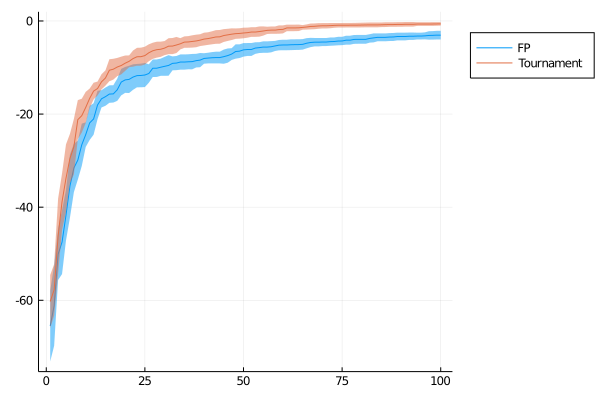

In [327]:
μ_fp = mean(fits_fp, dims=2)
σ_fp = std(fits_fp, dims=2)
μ_tourney = mean(fits_tourney, dims=2)
σ_tourney = std(fits_tourney, dims=2)
plot(μ_fp, ribbon=σ_fp, label="FP", legend=:outertopright)
plot!(μ_tourney, ribbon=σ_tourney, label="Tournament")

<div class="alert alert-success">
    <b>Exercise 5</b>
    <br/>
We now have many parameter choices: population size, mutation function, mutation rate, tournament size if using tournament selection, crossover function, number of elites. Using a maximum of 10000 <b>evaluations</b> (ie 100 generations with a population of 100), compare these parameter choices. What is the best value you can reach with $n=10$? Do the parameter results you get generalize to higher values of $n$? The best value should include the average and standard deviation over multiple runs.
    <br/>
</div>

In [423]:
function mutate(ind::FloatInd; mutation_rate::Float64=mutation_rate)
    new_genes = copy(ind.genes)
    for i in eachindex(new_genes)
        if rand() < mutation_rate
            new_genes[i] = rand()
        end
    end
    FloatInd(new_genes, -Inf)
end

mutate (generic function with 2 methods)

In [436]:
function mutate_mod(ind::FloatInd; mutation_rate::Float64=mutation_rate)
    new_genes = copy(ind.genes)
    for i in eachindex(new_genes)
        if rand() < mutation_rate
            new_genes[i] = ind.genes[i] + 0.2 * rand() - 0.1
        end
    end
    FloatInd(new_genes, -Inf)
end

mutate_mod (generic function with 1 method)

In [434]:
function tournament_select(population::Array{<:Individual}; tournament_size::Integer=tournament_size)
    tournament = sample(population, tournament_size)
    sort!(tournament, rev=true)[1]
end

tournament_select (generic function with 1 method)

In [502]:
initialize() = float_init(100, 10) # population size, number of genes n
mutate = mutate
mutation_rate = 0.5/10 # x/number of genes n
select = tournament_select
tournament_size = 15
crossover = uniform_crossover
num_elites = 0

fits = zeros(100, 100)
for i in 1:100
    fits[:, i] = ga(100) # 100 generations
    println(i, " ", fits[end, i])
end

1 -0.36543422239472534
2 -0.1626584973178069
3 -0.5242452896190741
4 -0.14696848953029473
5 -0.33911385773271263
6 -0.21407399148309025
7 -0.5113450534104942
8 -0.43936768696497097
9 -0.09677214982571058
10 -0.4265137047321872
11 -0.028193330722388055
12 -0.9712571838958866
13 -0.19263617364731545
14 -0.7907689614376778
15 -0.06878370320808358
16 -0.17213837146903188
17 -0.1970609668005494
18 -0.13604049187732414
19 -0.233408980724775
20 -0.2042082080571248
21 -0.45050384178603053
22 -0.44477729784057374
23 -0.1692254371131554
24 -0.3263446611202312
25 -0.5408737644005015
26 -0.10951413642725072
27 -0.45075595326041196
28 -0.11443341732946521
29 -0.18749970721026443
30 -0.14018034688095327
31 -0.4245721028997025
32 -0.6437735177222521
33 -0.36382336579369223
34 -0.3551852750002382
35 -0.2297590129467295
36 -0.2468308158200898
37 -0.07036716915057184
38 -0.11189404624001043
39 -0.15658462354892322
40 -0.2393353525836801
41 -0.20819973578373663
42 -0.5435477784269551
43 -0.15144630276584

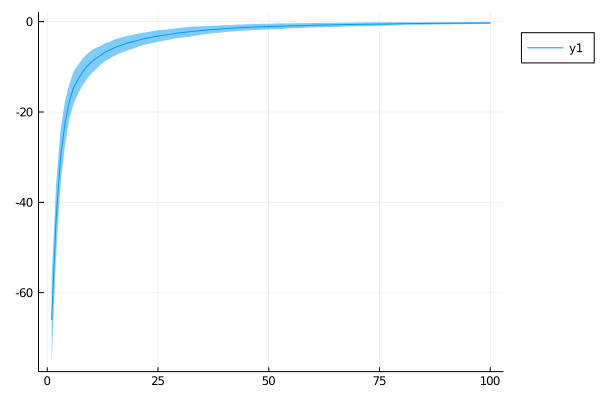

In [503]:
μ = mean(fits, dims=2)
σ = std(fits, dims=2)
plot(μ, ribbon=σ, legend=:outertopright)

In [504]:
println("μ last Generation: ", μ[end])

μ last Generation: -0.29311507683811044


<div class="alert alert-success">
    <b>Exercise 6</b>
    <br/>
Run the same analysis for the binary problem OneMax. Compare this result to the $(1+1)$ and $(1+\lambda)$ EAs from the first class. Which method is the best?
    <br/>
</div>

In [522]:
population_size = 10
n = 100
generations = 200
initialize() = bit_init(population_size, n) # population size, number of genes n
mutate = mutate
mutation_rate = 0.5/10 # x/number of genes n
select = tournament_select
tournament_size = 15
crossover = uniform_crossover
num_elites = 2

n_trials = 20

fits_bin = zeros(generations, n_trials)
for i in 1:n_trials
    fits_bin[:, i] = ga(generations) # 100 generations
    println(i, " ", fits_bin[end, i])
end

1 100.0
2 100.0
3 100.0
4 100.0
5 100.0
6 100.0
7 100.0
8 100.0
9 100.0
10 100.0
11 100.0
12 100.0
13 100.0
14 100.0
15 100.0
16 100.0
17 100.0
18 99.0
19 100.0
20 100.0


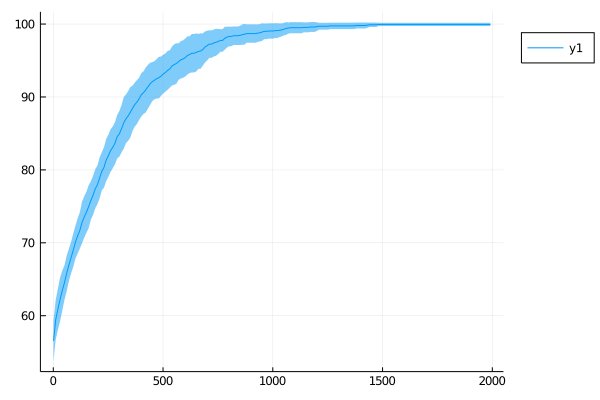

In [529]:
μ_bin = mean(fits_bin, dims=2)
σ_bin = std(fits_bin, dims=2)
plot(1:population_size:generations*population_size, μ_bin, ribbon=σ_bin, legend=:outertopright)

In [526]:
println("μ_bin last Generation: ", μ_bin[end])

μ_bin last Generation: 99.95


In [527]:
# The GA does need much fewer iterations to converge than the (1+1) and (1+𝜆) algorithms